In [1]:
import sys
import uproot3 as uproot
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
import pickle
import xgboost as xgb

from hyperopt import hp, fmin, tpe, Trials
from hyperopt.pyll.base import scope
from tqdm import tqdm

In [2]:
%matplotlib inline
plt.ion()

In [3]:
# data frame to hold all data
#datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/electronPhoton/TrainingTree_ElectronPhotonSeparation_RHC_Nov2023.root")["trainingTree"]
datafile = uproot.open("/Users/patrick/Documents/MicroBooNE/CrossSections/NuePiXSec_Analysis/BDTTraining/electronPhoton/TrainingTree_ElectronPhotonSeparation_RHC_Feb2024.root")["trainingTree"]
variables = (
    "isSignal",
    
    "n_showers_contained",
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    "shrPCA1CMed_5cm",
    "CylFrac2h_1cm",
    "DeltaRMS2h",
    "shrMCSMom",
     
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr2_trackEndProximity",
    "shr2_pfpgeneration",
    
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_dot",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_dot",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_dot",
    "secondshower_V_anglediff"
)

df = pd.DataFrame(datafile.arrays(namedecode='utf-8', branches=variables))

# shuffle to avoid intrinsic sample being at start
#df = df.sample(frac=1).reset_index(drop=True)

In [4]:
print(df.shape) 
print(df.keys())
df.head()

(58255, 29)
Index(['isSignal', 'n_showers_contained', 'shr_distance',
       'shr_trkfit_gap10_dedx_max', 'shr_trkfit_2cm_dedx_max', 'shrmoliereavg',
       'shr_energyFraction', 'shrsubclusters', 'shrPCA1CMed_5cm',
       'CylFrac2h_1cm', 'DeltaRMS2h', 'shrMCSMom', 'shr_energy_second_cali',
       'shr2_distance', 'shr12_p1_dstart', 'shr2_trackEndProximity',
       'shr2_pfpgeneration', 'secondshower_Y_nhit', 'secondshower_Y_vtxdist',
       'secondshower_Y_dot', 'secondshower_Y_anglediff', 'secondshower_U_nhit',
       'secondshower_U_vtxdist', 'secondshower_U_dot',
       'secondshower_U_anglediff', 'secondshower_V_nhit',
       'secondshower_V_vtxdist', 'secondshower_V_dot',
       'secondshower_V_anglediff'],
      dtype='object')


,isSignal,n_showers_contained,shr_distance,shr_trkfit_gap10_dedx_max,shr_trkfit_2cm_dedx_max,shrmoliereavg,shr_energyFraction,shrsubclusters,shrPCA1CMed_5cm,CylFrac2h_1cm,...,secondshower_Y_dot,secondshower_Y_anglediff,secondshower_U_nhit,secondshower_U_vtxdist,secondshower_U_dot,secondshower_U_anglediff,secondshower_V_nhit,secondshower_V_vtxdist,secondshower_V_dot,secondshower_V_anglediff
0,True,4.0,3.246621,1.951385,2.137975,4.835227,0.735451,38.0,0.652030,0.106017,...,0.415677,146.163208,16.0,32.714840,0.806648,108.138741,72.0,13.779519,0.999478,26.145485
1,True,2.0,0.772413,2.314346,1.962590,1.209950,0.942899,23.0,0.978146,0.594104,...,0.940250,0.823956,12.0,110.108917,0.464281,1.659882,10.0,85.420425,0.958979,4.433258
2,True,1.0,1.133977,2.208778,2.433833,5.661669,1.000000,7.0,0.759502,0.250000,...,0.839649,26.656677,20.0,229.293777,0.724312,51.278198,45.0,57.974194,0.999934,166.264496
3,True,1.0,9.111749,2.024169,2.040720,2.960321,1.000000,29.0,0.664011,0.086512,...,0.823891,16.496513,12.0,50.884518,0.544624,21.422005,9.0,79.926125,0.734381,20.842312
4,True,2.0,5.480277,2.741314,1.299153,4.256455,0.946879,37.0,0.673379,0.035833,...,0.678921,109.965759,6.0,40.081612,0.925875,161.879410,77.0,53.494984,0.189319,157.593414


In [5]:
# calculate neg / pos weight
scale_weight = (df.query('isSignal == 0')).shape[0] / (df.query('isSignal == 1')).shape[0]
print(scale_weight)

2.077390385631273


In [6]:
print((df.query('isSignal == 0')).shape[0])
print((df.query('isSignal == 1')).shape[0])

39325
18930


In [7]:
# splitting into testing and training samples
df_train, df_test = train_test_split(df, test_size = 0.3, random_state = 1)
labels_train = df_train["isSignal"]
labels_test = df_test["isSignal"]

df_train_sig = df_train.query("isSignal == True")
df_train_bkg = df_train.query("isSignal == False")
df_test_sig = df_test.query("isSignal == True")
df_test_bkg = df_test.query("isSignal == False")

In [8]:
# convert to DMatrix format
missing_value = 9999
bdt_vars = {
    "n_showers_contained",
    "shr_distance",
    "shr_trkfit_gap10_dedx_max",
    "shr_trkfit_2cm_dedx_max",
    "shrmoliereavg",
    "shr_energyFraction",
    "shrsubclusters",
    "shrPCA1CMed_5cm",
    "CylFrac2h_1cm",
    "DeltaRMS2h",
    "shrMCSMom",
     
    "shr_energy_second_cali",
    "shr2_distance",
    "shr12_p1_dstart",
    "shr2_trackEndProximity",
    "shr2_pfpgeneration",
    
    "secondshower_Y_nhit",
    "secondshower_Y_vtxdist",
    "secondshower_Y_dot",
    "secondshower_Y_anglediff",
    "secondshower_U_nhit",
    "secondshower_U_vtxdist",
    "secondshower_U_dot",
    "secondshower_U_anglediff",
    "secondshower_V_nhit",
    "secondshower_V_vtxdist",
    "secondshower_V_dot",
    "secondshower_V_anglediff"
}

xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

xgb_test_dict = xgb.DMatrix(df_test[bdt_vars], label=labels_test, missing=missing_value, feature_names=bdt_vars)
xgb_test_sig_dict = xgb.DMatrix(df_test_sig[bdt_vars], label=df_test_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
xgb_test_bkg_dict = xgb.DMatrix(df_test_bkg[bdt_vars], label=df_test_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)

/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_15990/2372294200.py:36: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_dict = xgb.DMatrix(df_train[bdt_vars], label=labels_train, missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_15990/2372294200.py:37: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_sig_dict = xgb.DMatrix(df_train_sig[bdt_vars], label=df_train_sig["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l68t7zdd3tngj9l8__x4bmrh0000gq/T/ipykernel_15990/2372294200.py:38: FutureWarning: Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.
  xgb_train_bkg_dict = xgb.DMatrix(df_train_bkg[bdt_vars], label=df_train_bkg["isSignal"], missing=missing_value, feature_names=bdt_vars)
/var/folders/2x/l6

In [8]:
# configuring XGBoost 
xgb_param = {'booster': 'dart',
        'max_depth':5,
        'eta': 0.03,
        'gamma': 1,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 0 }

num_round = 400
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [9]:
# HyperOpt
#{'colsample_bytree': 0.8507163619553273,
# 'eta': 0.09041903083032421,
# 'gamma': 1.788247151343299,
# 'max_depth': 5,
# 'min_child_weight': 4.989822074413174,
# 'subsample': 0.6952159209607586}
#350

# configuring XGBoost (Optimised values using HyperOpt)
xgb_param = {'booster': 'dart',
        'max_depth':6,
        'eta': 0.05,
        'gamma': 0.75,
        'min_child_weight': 5.0,
        'subsample': 0.75,
        'objective':'binary:logistic',
        'tree_method':'hist',
        'rate_drop': 0.1,
        'skip_drop': 0.5,    
        'scale_pos_weight': scale_weight,
        'nthread' : 6,
        'random_state': 27} #27}

num_round = 200
progress = dict()

watchlist = [(xgb_train_dict, 'train'), (xgb_test_dict, 'test'), (xgb_test_sig_dict, 'test_sig'), (xgb_test_bkg_dict, 'test_bkg')]

In [10]:
# training
bdt = xgb.train(xgb_param, xgb_train_dict, num_round, watchlist, evals_result=progress, verbose_eval=False)

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)


In [17]:
# save pickle 
pickle.dump(bdt, open("electronPhotonBDT.pickle.dat", "wb"))

In [18]:
# load from pickle
bdt = pickle.load(open("electronPhotonBDT.pickle.dat", "rb"))

In [19]:
# save model
bdt.save_model("bdt_electronPhoton.model")
bdt.save_model("bdt_electronPhoton.json")

In [20]:
bdt.dump_model("bdt_electronPhotondump.txt")

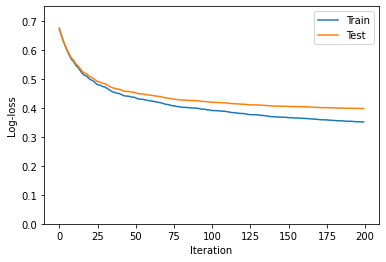

0.3509666863239427 0.3975086494855663


In [21]:
# plot training rate
results = progress
epochs = len(results['train']['logloss'])
x_axis = range(0, epochs)

fig, ax = plt.subplots()
ax.plot(x_axis, results['train']['logloss'], label='Train')
ax.plot(x_axis, results['test']['logloss'], label='Test')
ax.legend()
plt.ylim(0, 0.75)
plt.xlabel("Iteration")
plt.ylabel("Log-loss")
plt.show()

print(results['train']['logloss'][-1], results['test']['logloss'][-1])
#fig.savefig("training_rate_electronphoton_rhc.pdf", format="pdf")

<Figure size 1440x1440 with 0 Axes>

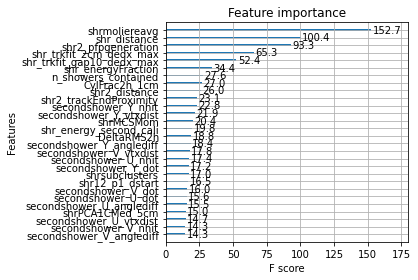

In [22]:
# plot importances
importance = bdt.get_score(importance_type="gain")

for key in importance.keys():
        importance[key] = round(importance[key],1)

# plotting importances of variables
plt.figure(figsize=(20,20),facecolor='white')
a = xgb.plot_importance(importance,max_num_features=30,importance_type='gain')
plt.xlim(0, 180)
plt.tight_layout()
#plt.savefig("feature_importance_electronphoton_rhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

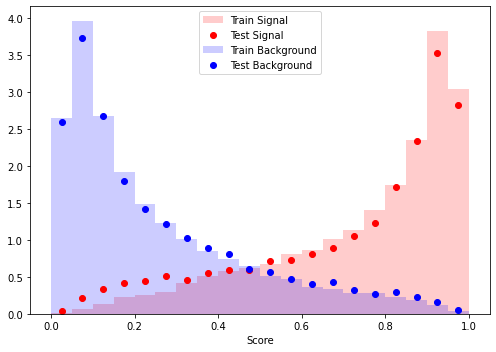

In [23]:
# plot test vs training
predictions_train_sig = bdt.predict(xgb_train_sig_dict)
predictions_train_bkg = bdt.predict(xgb_train_bkg_dict)
predictions_test_sig = bdt.predict(xgb_test_sig_dict)
predictions_test_bkg = bdt.predict(xgb_test_bkg_dict)

hist_range=[0,1.0]
n_bins=20

plt.figure(figsize=(7,5))
plt.hist(predictions_train_sig,bins=n_bins, range=hist_range, density=True,alpha=0.2,color='red',label='Train Signal' )
counts,bin_edges = np.histogram(predictions_test_sig,bins=n_bins,range=hist_range,density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle="None",color='red',label='Test Signal')

plt.hist(predictions_train_bkg, bins = n_bins, range = hist_range, density = True, alpha = 0.2, color = 'blue', label = r'Train Background')
counts,bin_edges = np.histogram(predictions_test_bkg,bins = n_bins, range= hist_range,density = True)
bin_centers = (bin_edges[:-1] +  bin_edges[1:])/2.
plt.plot(bin_centers,counts,marker='o',linestyle ="None",color='blue',label = r'Test Background')
plt.legend()

plt.xlabel("Score")

plt.tight_layout()

#plt.savefig("performance_electronphoton_rhc.pdf", format="pdf")

<Figure size 432x288 with 0 Axes>

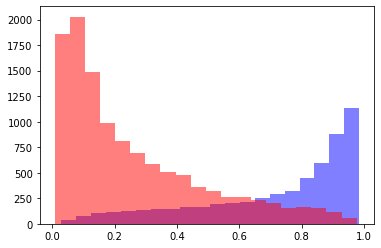

In [15]:
# create plot of predictions (testing samples)
num_bins = 20

plt.hist(predictions_test_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_test_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

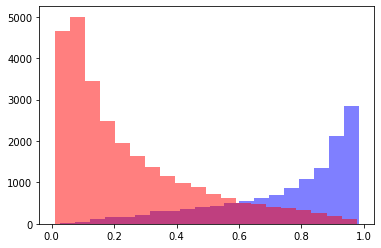

In [16]:
# create plot of predictions (training samples)
num_bins = 20
   
plt.hist(predictions_train_sig, num_bins, color ='blue', alpha = 0.5)
plt.hist(predictions_train_bkg, num_bins, color ='red', alpha = 0.5)

plt.show()

In [15]:
# Hyper parameter optimisation
# Un-tunded base case estimator to compare score
params_base = {'booster': 'dart',
               'objective': 'binary:logistic',
               'tree_method': 'hist',
               'rate_drop': 0.1,
               'skip_drop': 0.5,
               'scale_pos_weight': scale_weight,
               'random_state': 27}

base_model = xgb.train(params = params_base,
                       dtrain = xgb_train_dict,
                       num_boost_round = 250,
                       evals = [(xgb_test_dict,'eval')],
                       early_stopping_rounds=10,
                       verbose_eval = 20)

y_pred_base = base_model.predict(xgb_test_dict)

base_score = log_loss(df_test["isSignal"].values, y_pred_base)
print(base_score)

[0]	eval-logloss:0.59761
[20]	eval-logloss:0.42149
[40]	eval-logloss:0.41393
[60]	eval-logloss:0.41294
[80]	eval-logloss:0.41158
[81]	eval-logloss:0.41152
0.41152015381803847


In [16]:
# Simple Cross Val score as function to be optimised
def score(params):
    
    ps = {'eta': params['eta'],
         'max_depth': params['max_depth'], 
         'gamma': params['gamma'],
         'min_child_weight': params['min_child_weight'], 
         'subsample': params['subsample'], 
         'colsample_bytree': params['colsample_bytree'], 
         'verbosity': 1, 
         'objective': 'binary:logistic',
         'booster': 'dart',
         'eval_metric': 'logloss', 
         'tree_method': 'hist', 
         'rate_drop': 0.1,
         'skip_drop': 0.5,    
         'scale_pos_weight': scale_weight,
         'random_state': 27,
         }
    model = xgb.train(ps,xgb_train_dict, params['n_round'], [(xgb_test_dict, 'eval')], early_stopping_rounds=10, verbose_eval = False)
    y_pred = model.predict(xgb_test_dict)
    score = log_loss(df_test["isSignal"].values, y_pred)

    return score

In [17]:
# Define parameter space
param_space = {'eta': hp.uniform('eta', 0.01, 0.3), 
               'n_round': scope.int(hp.quniform('n_round', 100, 400, 50)),
               'max_depth': scope.int(hp.quniform('max_depth', 3, 6, 1)), 
               'gamma': hp.uniform('gamma', 0.5, 10), 
               'min_child_weight': hp.uniform('min_child_weight', 0.5, 10),
               'subsample': hp.uniform('subsample', 0.1, 1), 
               'colsample_bytree': hp.uniform('colsample_bytree', 0.1, 1),  
              }


In [18]:
# Run optimiser with tpe
%time
trials = Trials()

hopt = fmin(fn = score,
            space = param_space, 
            algo = tpe.suggest, 
            max_evals = 250, ## 100
            trials = trials, 
           )

params_best = hopt
params_best['max_depth'] = int(hopt['max_depth'])
n_rounds_best = int(hopt['n_round'])
del params_best['n_round']
print(params_best)
print(n_rounds_best)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 6.91 µs
  0%|                                                                                         | 0/250 [00:00<?, ?trial/s, best loss=?]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  0%|▏                                                            | 1/250 [00:26<1:49:06, 26.29s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▍                                                            | 2/250 [01:03<2:14:41, 32.59s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  1%|▋                                                            | 3/250 [01:15<1:36:43, 23.49s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|▉                                                            | 4/250 [02:11<2:27:48, 36.05s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▏                                                           | 5/250 [03:56<4:09:42, 61.15s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  2%|█▍                                                           | 6/250 [05:14<4:31:53, 66.86s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|█▋                                                          | 7/250 [08:03<6:46:04, 100.26s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  3%|█▉                                                           | 8/250 [08:46<5:30:37, 81.97s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▏                                                          | 9/250 [09:01<4:05:27, 61.11s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▍                                                         | 10/250 [10:00<4:01:45, 60.44s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  4%|██▋                                                         | 11/250 [10:42<3:37:34, 54.62s/trial, best loss: 0.4060583914807248]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|██▊                                                        | 12/250 [12:04<4:09:24, 62.88s/trial, best loss: 0.40605732955029855]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  5%|███                                                        | 13/250 [12:21<3:13:23, 48.96s/trial, best loss: 0.40605732955029855]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▎                                                       | 14/250 [12:52<2:52:02, 43.74s/trial, best loss: 0.40605732955029855]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▌                                                       | 15/250 [15:02<4:33:09, 69.74s/trial, best loss: 0.40605732955029855]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  6%|███▊                                                       | 16/250 [15:38<3:52:18, 59.57s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████                                                       | 17/250 [15:52<2:58:22, 45.93s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  7%|████▏                                                      | 18/250 [19:24<6:09:47, 95.64s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▍                                                     | 19/250 [22:57<8:24:09, 130.95s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▋                                                     | 20/250 [24:08<7:13:18, 113.03s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  8%|████▉                                                      | 21/250 [24:58<5:59:11, 94.11s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|█████▏                                                     | 22/250 [25:16<4:30:31, 71.19s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



  9%|█████▍                                                     | 23/250 [25:55<3:52:52, 61.55s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█████▋                                                     | 24/250 [27:03<3:58:44, 63.38s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|█████▉                                                     | 25/250 [27:21<3:07:17, 49.94s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 10%|██████▏                                                    | 26/250 [28:00<2:54:09, 46.65s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|██████▎                                                    | 27/250 [29:11<3:20:49, 54.03s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 11%|██████▌                                                    | 28/250 [31:40<5:04:51, 82.39s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|██████▊                                                    | 29/250 [32:00<3:54:58, 63.79s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|███████                                                    | 30/250 [32:41<3:28:07, 56.76s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 12%|███████▎                                                   | 31/250 [33:30<3:19:15, 54.59s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████▌                                                   | 32/250 [34:21<3:14:08, 53.43s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 13%|███████▊                                                   | 33/250 [35:05<3:02:35, 50.49s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████                                                   | 34/250 [36:52<4:02:47, 67.44s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████▎                                                  | 35/250 [37:14<3:13:30, 54.00s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 14%|████████▍                                                  | 36/250 [37:55<2:58:19, 50.00s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|████████▋                                                  | 37/250 [39:53<4:10:13, 70.48s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 15%|████████▉                                                  | 38/250 [40:16<3:18:05, 56.06s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▏                                                 | 39/250 [40:35<2:37:54, 44.90s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▍                                                 | 40/250 [40:53<2:08:59, 36.86s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 16%|█████████▋                                                 | 41/250 [41:10<1:48:09, 31.05s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|█████████▉                                                 | 42/250 [41:15<1:20:51, 23.32s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 17%|██████████▏                                                | 43/250 [41:41<1:22:56, 24.04s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▍                                                | 44/250 [41:57<1:13:47, 21.49s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▌                                                | 45/250 [42:51<1:46:49, 31.27s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 18%|██████████▊                                                | 46/250 [43:30<1:54:04, 33.55s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|███████████                                                | 47/250 [44:17<2:07:29, 37.68s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 19%|███████████▎                                               | 48/250 [44:35<1:47:27, 31.92s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████▌                                               | 49/250 [44:48<1:27:19, 26.07s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|███████████▊                                               | 50/250 [45:55<2:07:45, 38.33s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 20%|████████████                                               | 51/250 [46:13<1:47:39, 32.46s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|████████████▎                                              | 52/250 [46:19<1:20:30, 24.40s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 21%|████████████▌                                              | 53/250 [47:27<2:02:35, 37.34s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|████████████▋                                              | 54/250 [48:04<2:02:23, 37.47s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|████████████▉                                              | 55/250 [48:43<2:02:59, 37.84s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 22%|█████████████▏                                             | 56/250 [49:20<2:01:09, 37.47s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|█████████████▍                                             | 57/250 [50:01<2:04:10, 38.60s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 23%|█████████████▋                                             | 58/250 [51:09<2:31:32, 47.36s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|█████████████▉                                             | 59/250 [51:27<2:03:19, 38.74s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|██████████████▏                                            | 60/250 [51:39<1:36:41, 30.54s/trial, best loss: 0.40437018290976084]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 24%|██████████████▍                                            | 61/250 [53:02<2:26:11, 46.41s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████▋                                            | 62/250 [56:32<4:59:23, 95.55s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 25%|██████████████▌                                           | 63/250 [58:37<5:24:38, 104.16s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████▎                                         | 64/250 [1:01:16<6:13:50, 120.59s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████▌                                         | 65/250 [1:03:56<6:49:03, 132.66s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 26%|██████████████▊                                         | 66/250 [1:06:22<6:58:40, 136.53s/trial, best loss: 0.40358530245340846]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|███████████████                                         | 67/250 [1:11:36<9:38:29, 189.67s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 27%|██████████████▉                                        | 68/250 [1:16:56<11:34:31, 228.96s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|███████████████▏                                       | 69/250 [1:19:28<10:21:02, 205.87s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|███████████████▍                                       | 70/250 [1:23:25<10:45:16, 215.09s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 28%|███████████████▉                                        | 71/250 [1:25:11<9:04:12, 182.42s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|████████████████▏                                       | 72/250 [1:26:10<7:11:16, 145.37s/trial, best loss: 0.40335648770986265]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 29%|████████████████▋                                        | 73/250 [1:31:34<9:46:52, 198.94s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████▌                                       | 74/250 [1:36:57<11:32:30, 236.08s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|████████████████▊                                       | 75/250 [1:40:57<11:32:02, 237.27s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 30%|█████████████████▎                                       | 76/250 [1:42:28<9:21:13, 193.52s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|█████████████████▌                                       | 77/250 [1:46:10<9:42:12, 201.92s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 31%|█████████████████▊                                       | 78/250 [1:47:55<8:15:52, 172.98s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████                                       | 79/250 [1:48:29<6:14:00, 131.23s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████▏                                      | 80/250 [1:53:32<8:38:15, 182.92s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 32%|██████████████████▍                                      | 81/250 [1:57:25<9:17:29, 197.93s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|██████████████████▋                                      | 82/250 [2:01:10<9:36:42, 205.97s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 33%|██████████████████▉                                      | 83/250 [2:02:02<7:24:17, 159.63s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████▏                                     | 84/250 [2:07:00<9:17:06, 201.37s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████                                     | 85/250 [2:12:02<10:36:15, 231.37s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 34%|███████████████████▌                                     | 86/250 [2:14:03<9:01:44, 198.20s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|███████████████████▊                                     | 87/250 [2:16:43<8:27:21, 186.76s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 35%|████████████████████                                     | 88/250 [2:20:18<8:47:38, 195.42s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▎                                    | 89/250 [2:23:57<9:03:22, 202.50s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▌                                    | 90/250 [2:24:33<6:46:42, 152.51s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 36%|████████████████████▋                                    | 91/250 [2:29:57<9:00:08, 203.83s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|████████████████████▉                                    | 92/250 [2:30:49<6:57:19, 158.48s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 37%|█████████████████████▏                                   | 93/250 [2:33:37<7:01:44, 161.17s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████▍                                   | 94/250 [2:35:29<6:20:58, 146.53s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████▋                                   | 95/250 [2:40:27<8:16:02, 192.02s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 38%|█████████████████████▉                                   | 96/250 [2:44:15<8:40:02, 202.61s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|██████████████████████                                   | 97/250 [2:45:29<6:58:12, 164.00s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 39%|██████████████████████▎                                  | 98/250 [2:46:09<5:21:50, 127.04s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▌                                  | 99/250 [2:47:06<4:26:16, 105.80s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▍                                 | 100/250 [2:48:58<4:29:39, 107.86s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 40%|██████████████████████▌                                 | 101/250 [2:51:45<5:11:39, 125.50s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|██████████████████████▊                                 | 102/250 [2:52:33<4:12:30, 102.37s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 41%|███████████████████████▍                                 | 103/250 [2:53:17<3:27:25, 84.66s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▋                                 | 104/250 [2:54:06<3:00:02, 73.99s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▌                                | 105/250 [2:58:09<5:01:30, 124.76s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 42%|███████████████████████▋                                | 106/250 [3:01:55<6:12:32, 155.23s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|███████████████████████▉                                | 107/250 [3:03:15<5:15:40, 132.45s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 43%|████████████████████████▏                               | 108/250 [3:05:49<5:28:48, 138.94s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▍                               | 109/250 [3:10:47<7:18:42, 186.69s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▋                               | 110/250 [3:12:40<6:23:54, 164.53s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 44%|████████████████████████▊                               | 111/250 [3:17:30<7:48:17, 202.14s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|█████████████████████████                               | 112/250 [3:18:49<6:20:06, 165.26s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 45%|█████████████████████████▎                              | 113/250 [3:22:32<6:57:18, 182.76s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▌                              | 114/250 [3:24:48<6:22:27, 168.74s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▊                              | 115/250 [3:25:40<5:00:34, 133.59s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 46%|█████████████████████████▉                              | 116/250 [3:26:44<4:11:24, 112.57s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████▏                             | 117/250 [3:28:01<3:45:54, 101.91s/trial, best loss: 0.4026482548746486]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 47%|██████████████████████████▍                             | 118/250 [3:31:45<5:05:00, 138.64s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████▋                             | 119/250 [3:33:46<4:50:58, 133.27s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|██████████████████████████▉                             | 120/250 [3:36:24<5:05:15, 140.89s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 48%|███████████████████████████                             | 121/250 [3:38:14<4:42:36, 131.44s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|███████████████████████████▎                            | 122/250 [3:38:52<3:40:54, 103.55s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 49%|████████████████████████████                             | 123/250 [3:39:38<3:02:25, 86.18s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|███████████████████████████▊                            | 124/250 [3:43:30<4:32:56, 129.97s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████                            | 125/250 [3:48:34<6:19:43, 182.27s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 50%|████████████████████████████▏                           | 126/250 [3:53:18<7:19:44, 212.78s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|████████████████████████████▍                           | 127/250 [3:58:14<8:07:16, 237.69s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 51%|████████████████████████████▋                           | 128/250 [4:00:58<7:18:15, 215.54s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|████████████████████████████▉                           | 129/250 [4:02:19<5:53:25, 175.25s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████                           | 130/250 [4:07:38<7:16:39, 218.33s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 52%|█████████████████████████████▎                          | 131/250 [4:09:48<6:20:36, 191.90s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████████████████████████████▌                          | 132/250 [4:15:04<7:30:35, 229.11s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 53%|█████████████████████████████▊                          | 133/250 [4:15:20<5:21:58, 165.11s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████                          | 134/250 [4:19:20<6:02:57, 187.74s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████▏                         | 135/250 [4:20:57<5:07:32, 160.46s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 54%|██████████████████████████████▍                         | 136/250 [4:22:08<4:13:39, 133.50s/trial, best loss: 0.4024269721780537]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|██████████████████████████████▋                         | 137/250 [4:25:55<5:04:23, 161.62s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 55%|██████████████████████████████▉                         | 138/250 [4:27:29<4:23:45, 141.30s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████▏                        | 139/250 [4:28:45<3:44:53, 121.57s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████▎                        | 140/250 [4:31:48<4:16:50, 140.09s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 56%|███████████████████████████████▌                        | 141/250 [4:34:31<4:27:14, 147.11s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|███████████████████████████████▊                        | 142/250 [4:36:08<3:57:32, 131.96s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 57%|████████████████████████████████                        | 143/250 [4:36:53<3:09:01, 105.99s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▎                       | 144/250 [4:40:41<4:11:36, 142.42s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▍                       | 145/250 [4:41:35<3:22:57, 115.97s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 58%|████████████████████████████████▋                       | 146/250 [4:46:58<5:08:47, 178.15s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|████████████████████████████████▉                       | 147/250 [4:49:25<4:49:51, 168.85s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 59%|█████████████████████████████████▏                      | 148/250 [4:51:54<4:36:45, 162.80s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▍                      | 149/250 [4:53:24<3:57:07, 140.86s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▌                      | 150/250 [4:57:30<4:47:28, 172.49s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 60%|█████████████████████████████████▊                      | 151/250 [5:00:06<4:36:17, 167.45s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████████████████████████████████                      | 152/250 [5:01:31<3:53:25, 142.91s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 61%|██████████████████████████████████▎                     | 153/250 [5:05:44<4:44:00, 175.68s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▍                     | 154/250 [5:09:50<5:15:02, 196.91s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▋                     | 155/250 [5:12:51<5:04:27, 192.29s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 62%|██████████████████████████████████▉                     | 156/250 [5:16:50<5:23:05, 206.23s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|███████████████████████████████████▏                    | 157/250 [5:17:25<3:59:51, 154.74s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 63%|███████████████████████████████████▍                    | 158/250 [5:18:36<3:18:57, 129.75s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████▌                    | 159/250 [5:21:08<3:26:49, 136.37s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|███████████████████████████████████▊                    | 160/250 [5:26:17<4:42:10, 188.12s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 64%|████████████████████████████████████                    | 161/250 [5:26:47<3:28:54, 140.84s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|████████████████████████████████████▎                   | 162/250 [5:30:57<4:14:26, 173.48s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 65%|████████████████████████████████████▌                   | 163/250 [5:33:55<4:13:31, 174.85s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|████████████████████████████████████▋                   | 164/250 [5:35:18<3:30:56, 147.17s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|████████████████████████████████████▉                   | 165/250 [5:38:50<3:55:58, 166.57s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 66%|█████████████████████████████████████▏                  | 166/250 [5:42:47<4:22:52, 187.77s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|█████████████████████████████████████▍                  | 167/250 [5:45:46<4:16:15, 185.25s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 67%|█████████████████████████████████████▋                  | 168/250 [5:47:25<3:37:37, 159.24s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|█████████████████████████████████████▊                  | 169/250 [5:48:27<2:55:50, 130.25s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|██████████████████████████████████████                  | 170/250 [5:52:23<3:35:51, 161.89s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 68%|██████████████████████████████████████▎                 | 171/250 [5:54:24<3:16:49, 149.48s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████▌                 | 172/250 [5:55:27<2:40:40, 123.60s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 69%|██████████████████████████████████████▊                 | 173/250 [5:57:32<2:39:19, 124.15s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|██████████████████████████████████████▉                 | 174/250 [5:59:21<2:31:26, 119.56s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████▉                 | 175/250 [5:59:50<1:55:27, 92.36s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 70%|███████████████████████████████████████▍                | 176/250 [6:19:01<8:25:33, 409.91s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|██████████████████████████████████████▉                | 177/250 [6:36:33<12:13:03, 602.51s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 71%|███████████████████████████████████████▏               | 178/250 [6:47:51<12:30:09, 625.13s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|██████████████████████████████████████▋               | 179/250 [7:20:52<20:21:17, 1032.08s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████▌               | 180/250 [7:29:07<16:55:52, 870.75s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 72%|███████████████████████████████████████               | 181/250 [8:35:53<34:43:16, 1811.54s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|███████████████████████████████████████▎              | 182/250 [9:10:37<35:45:41, 1893.26s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 73%|███████████████████████████████████████▌              | 183/250 [9:14:37<26:00:18, 1397.28s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▍              | 184/250 [9:15:48<18:19:18, 999.37s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▋              | 185/250 [9:18:05<13:22:27, 740.72s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 74%|████████████████████████████████████████▉              | 186/250 [9:36:20<15:03:18, 846.85s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|█████████████████████████████████████████▏             | 187/250 [9:54:51<16:12:25, 926.13s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 75%|████████████████████████████████████████▌             | 188/250 [10:11:37<16:21:52, 950.21s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|████████████████████████████████████████▊             | 189/250 [10:14:05<12:01:19, 709.50s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|█████████████████████████████████████████▊             | 190/250 [10:17:51<9:24:21, 564.36s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 76%|██████████████████████████████████████████             | 191/250 [10:19:54<7:04:38, 431.84s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|█████████████████████████████████████████▍            | 192/250 [10:55:16<15:07:51, 939.16s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 77%|████████████████████████████████████████▉            | 193/250 [11:14:31<15:53:36, 1003.80s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|█████████████████████████████████████████▉            | 194/250 [11:15:26<11:11:18, 719.26s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|██████████████████████████████████████████▉            | 195/250 [11:16:22<7:56:42, 520.04s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 78%|███████████████████████████████████████████            | 196/250 [11:16:37<5:31:45, 368.61s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|███████████████████████████████████████████▎           | 197/250 [11:17:01<3:54:25, 265.39s/trial, best loss: 0.4015902192474974]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 79%|██████████████████████████████████████████▊           | 198/250 [11:20:34<3:36:13, 249.50s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|██████████████████████████████████████████▉           | 199/250 [11:21:21<2:40:33, 188.90s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|███████████████████████████████████████████▏          | 200/250 [11:48:46<8:41:17, 625.54s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 80%|███████████████████████████████████████████▍          | 201/250 [11:59:10<8:30:38, 625.28s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|███████████████████████████████████████████▋          | 202/250 [12:02:54<6:43:55, 504.91s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 81%|███████████████████████████████████████████▊          | 203/250 [12:03:56<4:51:23, 371.99s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████          | 204/250 [12:04:29<3:27:06, 270.15s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████▎         | 205/250 [12:06:33<2:49:47, 226.39s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 82%|████████████████████████████████████████████▍         | 206/250 [12:09:36<2:36:25, 213.32s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|████████████████████████████████████████████▋         | 207/250 [12:11:22<2:09:46, 181.07s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 83%|████████████████████████████████████████████▉         | 208/250 [12:13:33<1:56:15, 166.09s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|█████████████████████████████████████████████▏        | 209/250 [12:14:46<1:34:20, 138.06s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|█████████████████████████████████████████████▎        | 210/250 [12:18:23<1:47:54, 161.87s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 84%|█████████████████████████████████████████████▌        | 211/250 [12:23:08<2:09:14, 198.83s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|█████████████████████████████████████████████▊        | 212/250 [12:26:02<2:01:06, 191.23s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 85%|██████████████████████████████████████████████        | 213/250 [12:27:53<1:43:06, 167.20s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████▏       | 214/250 [12:30:15<1:35:46, 159.63s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████▍       | 215/250 [12:32:54<1:33:01, 159.47s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 86%|██████████████████████████████████████████████▋       | 216/250 [12:33:08<1:05:42, 115.95s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|██████████████████████████████████████████████▊       | 217/250 [12:35:48<1:10:58, 129.04s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 87%|███████████████████████████████████████████████       | 218/250 [12:39:34<1:24:26, 158.32s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████▎      | 219/250 [12:41:27<1:14:40, 144.54s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████▌      | 220/250 [12:42:52<1:03:22, 126.76s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 88%|███████████████████████████████████████████████▋      | 221/250 [12:45:50<1:08:38, 142.03s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|█████████████████████████████████████████████████▋      | 222/250 [12:46:07<48:51, 104.71s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 89%|██████████████████████████████████████████████████▊      | 223/250 [12:46:31<36:13, 80.50s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|███████████████████████████████████████████████████      | 224/250 [12:46:36<25:00, 57.70s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|███████████████████████████████████████████████████▎     | 225/250 [12:49:00<34:49, 83.56s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 90%|███████████████████████████████████████████████████▌     | 226/250 [12:49:28<26:46, 66.94s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|███████████████████████████████████████████████████▊     | 227/250 [12:51:20<30:54, 80.63s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 91%|███████████████████████████████████████████████████▉     | 228/250 [12:51:41<22:58, 62.65s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|████████████████████████████████████████████████████▏    | 229/250 [12:52:49<22:26, 64.10s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|████████████████████████████████████████████████████▍    | 230/250 [12:55:15<29:35, 88.80s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 92%|████████████████████████████████████████████████████▋    | 231/250 [12:57:11<30:43, 97.03s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|████████████████████████████████████████████████████▉    | 232/250 [12:57:53<24:08, 80.49s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 93%|█████████████████████████████████████████████████████    | 233/250 [12:58:14<17:46, 62.72s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████▎   | 234/250 [12:59:00<15:22, 57.63s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████▌   | 235/250 [13:00:29<16:46, 67.12s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 94%|█████████████████████████████████████████████████████▊   | 236/250 [13:02:58<21:20, 91.45s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|█████████████████████████████████████████████████████   | 237/250 [13:04:59<21:43, 100.31s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 95%|██████████████████████████████████████████████████████▎  | 238/250 [13:06:30<19:30, 97.57s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|██████████████████████████████████████████████████████▍  | 239/250 [13:07:10<14:44, 80.45s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|██████████████████████████████████████████████████████▋  | 240/250 [13:08:13<12:30, 75.03s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 96%|██████████████████████████████████████████████████████▉  | 241/250 [13:10:46<14:46, 98.55s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|███████████████████████████████████████████████████████▏ | 242/250 [13:12:15<12:46, 95.77s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 97%|██████████████████████████████████████████████████████▍ | 243/250 [13:14:11<11:52, 101.81s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████▋ | 244/250 [13:16:09<10:40, 106.67s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|██████████████████████████████████████████████████████▉ | 245/250 [13:17:38<08:26, 101.36s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 98%|████████████████████████████████████████████████████████ | 246/250 [13:18:11<05:23, 80.86s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|████████████████████████████████████████████████████████▎| 247/250 [13:18:18<02:55, 58.66s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



 99%|████████████████████████████████████████████████████████▌| 248/250 [13:18:39<01:34, 47.32s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|████████████████████████████████████████████████████████▊| 249/250 [13:19:20<00:45, 45.46s/trial, best loss: 0.40131929261004456]

/opt/homebrew/lib/python3.10/site-packages/xgboost/core.py:617: FutureWarning: Pass `evals` as keyword args.
  warnings.warn(msg, FutureWarning)



100%|████████████████████████████████████████████████████████| 250/250 [13:19:58<00:00, 191.99s/trial, best loss: 0.40131929261004456]
{'colsample_bytree': 0.8507163619553273, 'eta': 0.09041903083032421, 'gamma': 1.788247151343299, 'max_depth': 5, 'min_child_weight': 4.989822074413174, 'subsample': 0.6952159209607586}
350


In [19]:
print(params_best)
print(n_rounds_best)

{'colsample_bytree': 0.8507163619553273, 'eta': 0.09041903083032421, 'gamma': 1.788247151343299, 'max_depth': 5, 'min_child_weight': 4.989822074413174, 'subsample': 0.6952159209607586}
350
